In [1]:
!nvidia-smi

Mon Mar 17 19:14:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   35C    P8              1W /   35W |     305MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.data import Dataset

import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [3]:
class FolderDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 3, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [5]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# print("Setting Seed for the run, seed = {}".format(config.SEED))

# seed_everything(config.SEED)

transforms = T.Compose([T.Resize((68, 68)), T.ToTensor()])
print("------------ Creating Dataset ------------")
full_dataset = FolderDataset('./image_similarity/dataset/', transforms)

train_size = int(0.75 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

print("------------ Dataset Created ------------")
print("------------ Creating DataLoader ------------")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32
)

full_loader = torch.utils.data.DataLoader(
    full_dataset, batch_size=32
)

------------ Creating Dataset ------------
------------ Dataset Created ------------
------------ Creating DataLoader ------------


In [7]:
import numpy as np

# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

model.to(device)

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        noisy_imgs = noisy_imgs.to(device)
        images = images.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.169220
Epoch: 2 	Training Loss: 0.418494
Epoch: 3 	Training Loss: 0.359961
Epoch: 4 	Training Loss: 0.343379
Epoch: 5 	Training Loss: 0.333786
Epoch: 6 	Training Loss: 0.327202
Epoch: 7 	Training Loss: 0.322758
Epoch: 8 	Training Loss: 0.317718
Epoch: 9 	Training Loss: 0.313459
Epoch: 10 	Training Loss: 0.309504
Epoch: 11 	Training Loss: 0.296843
Epoch: 12 	Training Loss: 0.280154
Epoch: 13 	Training Loss: 0.271968
Epoch: 14 	Training Loss: 0.266856
Epoch: 15 	Training Loss: 0.262900
Epoch: 16 	Training Loss: 0.258717
Epoch: 17 	Training Loss: 0.255371
Epoch: 18 	Training Loss: 0.252836
Epoch: 19 	Training Loss: 0.250555
Epoch: 20 	Training Loss: 0.248546


torch.Size([32, 3, 68, 68])
torch.Size([32, 3, 68, 68])
noisy imgs:  (32, 3, 68, 68)
(32, 3, 68, 68)
(32, 68, 68, 3)


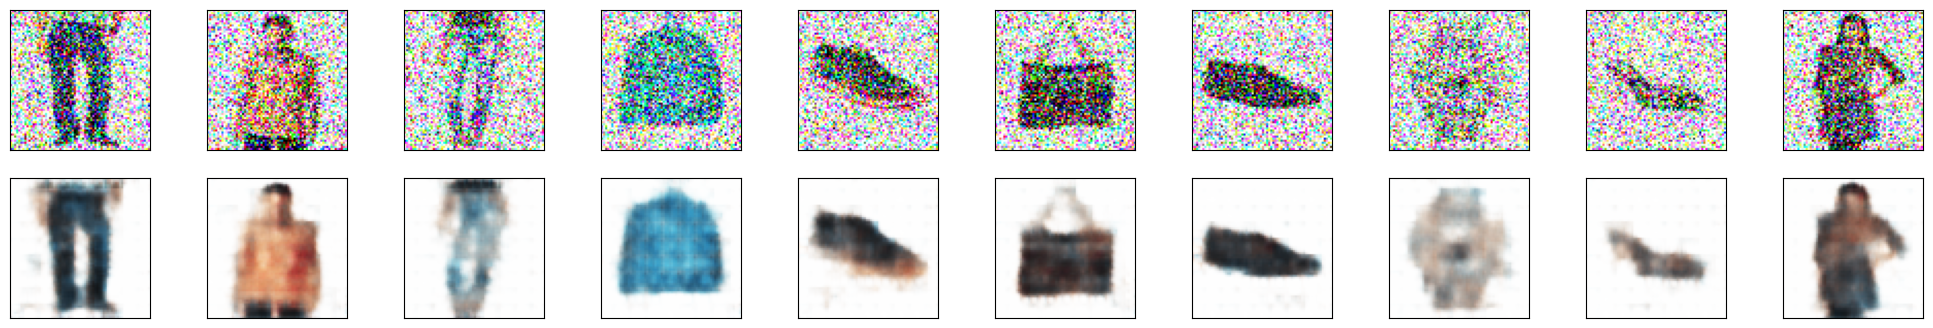

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

model.to('cpu')

# obtain one batch of test images
dataiter = iter(val_loader)
images, labels = next(dataiter)

print(images.shape)

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
print(output.shape)
# prep images for display
noisy_imgs = noisy_imgs.numpy()
print('noisy imgs: ', noisy_imgs.shape)
noisy_imgs = np.moveaxis(noisy_imgs, 1, -1)

batch_size = 32
# output is resized into a batch of images
output = output.view(batch_size, 3, 68, 68)
# use detach when it's an output that requires_grad
output = output.detach().numpy()
print(output.shape)
output = np.moveaxis(output, 1, -1)
print(output.shape)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()